In [1]:
import numpy as np
import torch
from torchvision import transforms
import apex
import data
import models

### Data Loading

In [2]:
batch_size = 8

train_dataset = data.XRayDataset(
    transform=transforms.Compose([
        transforms.Resize(2048),
        transforms.CenterCrop((2048,2048)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        ]
))

print("Sample:")
image, impression = train_dataset.__getitem__(0)
print("* Image size:", image.size())
print("* Impression:", impression)
print("* Vocab:")
print(train_dataset.vocab)

train_dataloader = torch.utils.data.dataloader.DataLoader(train_dataset,
                                                          collate_fn=data.collate_fn,
                                                          pin_memory=True,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          num_workers=batch_size)

Number of reports: 3851
Skipped: 3648 images
Sample:
* Image size: torch.Size([3, 2048, 2048])
* Impression: tensor([37, 38, 41, 36, 24, 35,  0, 26, 31, 28, 42, 43,  0, 47,  6, 47, 47, 47,
        47,  7])
* Vocab:
['k', 'o', 'i', 'p', 'j', "'", ')', 'd', 'x', '%', ':', '4', 'f', '5', 'e', '[', 'l', '1', 'c', 's', 'u', 'b', '9', '3', '0', '"', 'z', 'q', ' ', 'm', 'h', 'y', '6', 't', '-', 'r', 'n', 'w', '/', '>', '8', '7', 'g', '2', '.', 'a', 'v', '<', '(', ';']


### Build Model

In [3]:
embed_size = 128
hidden_size = 128
num_layers = 3
learning_rate = 0.001
memory_format = torch.channels_last
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = models.EncoderCNN(embed_size).to(device, memory_format=memory_format)
decoder = models.DecoderRNN(embed_size, hidden_size, len(train_dataset.vocab), num_layers).to(device)

criterion = torch.nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = apex.optimizers.FusedAdam(params, lr=learning_rate)

[encoder, decoder], optimizer = apex.amp.initialize([encoder, decoder], optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


### Train Model

In [4]:
num_epochs = 4
total_step = len(train_dataloader.dataset)//batch_size
encoder.train()
decoder.train()

print("Start training")

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(train_dataloader):

        # Set mini-batch dataset
        images = images.cuda(non_blocking=True).contiguous(memory_format=memory_format)
        captions = captions.cuda(non_blocking=True).contiguous()
        targets = torch.nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        encoder.zero_grad()
        decoder.zero_grad()

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        
        with apex.amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        optimizer.step()

        # Print log info
        if i % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}"
                  .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

Start training
Epoch [0/4], Step [0/435], Loss: 3.9344, Perplexity: 51.1323
Epoch [0/4], Step [100/435], Loss: 2.9513, Perplexity: 19.1316
Epoch [0/4], Step [200/435], Loss: 2.5882, Perplexity: 13.3057
Epoch [0/4], Step [300/435], Loss: 1.6900, Perplexity: 5.4192
Epoch [0/4], Step [400/435], Loss: 1.7159, Perplexity: 5.5617
Epoch [1/4], Step [0/435], Loss: 1.3660, Perplexity: 3.9195
Epoch [1/4], Step [100/435], Loss: 1.0193, Perplexity: 2.7712
Epoch [1/4], Step [200/435], Loss: 0.9829, Perplexity: 2.6723
Epoch [1/4], Step [300/435], Loss: 1.2340, Perplexity: 3.4348
Epoch [1/4], Step [400/435], Loss: 0.6003, Perplexity: 1.8226
Epoch [2/4], Step [0/435], Loss: 1.2177, Perplexity: 3.3792
Epoch [2/4], Step [100/435], Loss: 0.3509, Perplexity: 1.4203
Epoch [2/4], Step [200/435], Loss: 1.1692, Perplexity: 3.2196
Epoch [2/4], Step [300/435], Loss: 0.5666, Perplexity: 1.7622
Epoch [2/4], Step [400/435], Loss: 0.8651, Perplexity: 2.3753
Epoch [3/4], Step [0/435], Loss: 0.6964, Perplexity: 2.006

### Inference

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

encoder.eval()
decoder.eval()

DecoderRNN(
  (embed): Embedding(50, 128)
  (lstm): LSTM(128, 128, num_layers=3, batch_first=True)
  (linear): Linear(in_features=128, out_features=50, bias=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (layer_norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


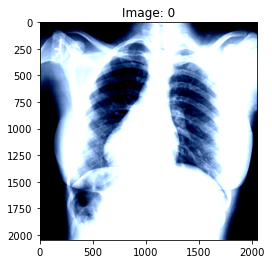

 Original: normal chest x-xxxx.
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


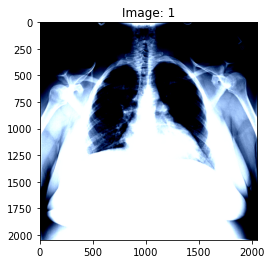

 Original: no acute pulmonary findings.
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


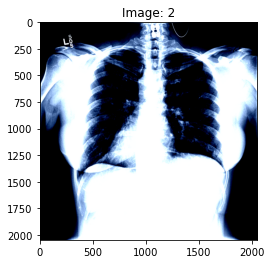

 Original: or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified."
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


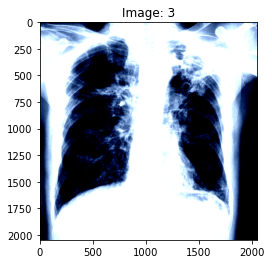

 Original: recommend short interval followup radiograph or ct thorax to document resolution."
Generated: normal chest. no acute cardiopulmonary abnormality. ."ring the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


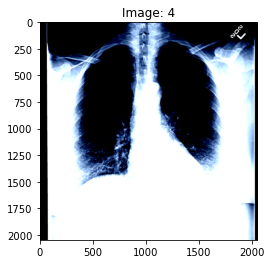

 Original: no acute cardiopulmonary abnormality.
Generated: normal chest. no acute cardiopulmonary abnormality. ."ring the l



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


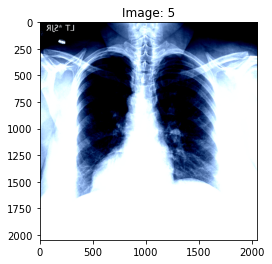

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: no acute cardiopulmonary findings.
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



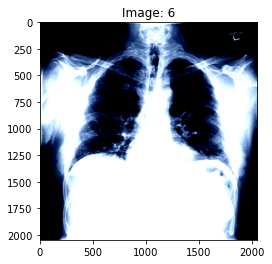

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 Original: basilar atelectasis. no confluent lobar consolidation or pleural effusion.
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



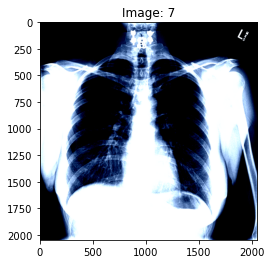

 Original: no acute cardiopulmonary disease.
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


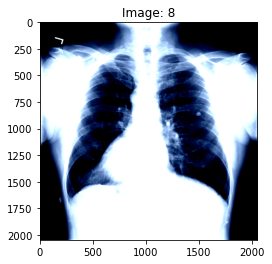

 Original: pleural mass or cardiac aneurysm. ct chest with contrast is recommended. these findings and recommendations were discussed xxxx. xxxx by dr. xxxx xxxx telephone at xxxx p.m. xxxx/xxxx. dr. xxxx<xxxx>technologist receipt of the results."
Generated: no acute cardiopulmonary abnormality. ."ring the lungs and conte



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


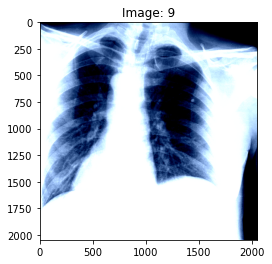

 Original: no acute cardiopulmonary process.
Generated: normal chest. no acute cardiopulmonary abnormality. ."ring the l



In [6]:
for index in range(0, 10):
    image, impression = train_dataset.__getitem__(index)
    image_tensor = image.unsqueeze(0).cuda()
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = list(sampled_ids[0].cpu().numpy())

    plt.title("Image: "+str(index))
    plt_img = np.moveaxis(image.numpy(), 0, -1)
    plt.imshow(plt_img)
    plt.show()

    print(" Original:", train_dataset.tokenizer.decode(impression))
    print("Generated:", train_dataset.tokenizer.decode(sampled_ids))
    print("")